In [1]:
import itertools
import numpy as np
from pymatgen import Structure
from pymatgen import Lattice
from pyxtal.symmetry import get_wyckoffs
from tqdm.notebook import tqdm
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd
import GPy
from camd.agent.generic import GPBatchUCB

from matplotlib import pyplot as plt
from numpy.random import randn
import warnings

from monty.serialization import loadfn, dumpfn

from pandas import DataFrame
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import os
from camd.experiment.dft import *
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import camd
from camd.agent.base import RandomAgent
from camd.agent.generic import GenericGPUCB
from camd.analysis import GenericMaxAnalyzer
from camd.experiment import ATFSampler
from camd.campaigns.base import Campaign
path = os.getcwd()

import pickle
from tqdm.notebook import tqdm
from pymatgen.analysis.diffraction import xrd
from pymatgen import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from pymatgen import Lattice
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
mpr = MPRester('xpFvqo6ae6RNF3rqM0WI')

from pymatgen.io.vasp import Outcar

In [2]:
scores = loadfn('/Users/handongling/CAMD-XRD/gridsearch/mp-7648/scores-mp-7648-density=1.7.json')
struc_coords = loadfn('/Users/handongling/CAMD-XRD/gridsearch/mp-7648/struc_coords-mp-7648-density=1.7.json')
rvalues=loadfn('/Users/handongling/CAMD-XRD/gridsearch/mp-7648/rvalues-mp-7648-density=1.7.json')
energies=loadfn('/Users/handongling/CAMD-XRD/gridsearch/mp-7648/energies-mp-7648-density=1.7.json')

In [3]:
mpid = 'mp-7648'

original_str = SpacegroupAnalyzer(mpr.get_structure_by_material_id(mpid)).get_conventional_standard_structure()

# SETUP
spg = SpacegroupAnalyzer(original_str).get_symmetry_dataset()['number']
a=original_str.lattice.a ; b=original_str.lattice.b; c=original_str.lattice.c 
alpha=original_str.lattice.alpha; beta=original_str.lattice.beta; gamma=original_str.lattice.gamma
print(spg,a,b,c,alpha,beta,gamma)
tracker = {}
for specie in original_str.species:
    if specie.as_dict()['element'] not in tracker:
        tracker[specie.as_dict()['element']] = 1
    else:
        tracker[specie.as_dict()['element']] += 1

atoms = [(tracker[key], key) for key in tracker]

sorteddict = list(reversed(sorted(tracker)))

species = []
for specie in sorteddict:
    for num in range(tracker[specie]):
        species.append(specie) 

20 5.088538 9.138582 8.334435 90.0 90.0 90.0


In [4]:
configuration = 5

scores = scores[configuration]
struc_coords = struc_coords[configuration]
rvalues = rvalues[configuration]
energies = energies[configuration]

In [5]:
strucs = []
lattice = Lattice.from_parameters(a,b,c,alpha,beta,gamma)

for m in range(len(struc_coords)):
    sites = []
    for j in list(struc_coords[m]):
        for k in j:
            sites.append(k)
    strucs.append(Structure(lattice, species, sites))
print(species,atoms)

['Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] [(8, 'Si'), (16, 'O')]


In [6]:
import pandas as pd
newdfdata = []
for i in [1]:
    candidates_all = []
    coords_all = []
    for j in range(5):
        experiments = pd.read_pickle(open('/Users/handongling/CAMD-XRD/gridsearch/mp-7648/GP-mp-7648-nquery=1-{}-correct/seed_data.pickle'.format(j), 'rb'))
#         for row in range(len(experiments)):
        sortedexp = experiments.sort_values(by='target', ascending = False)
        for pos in range(len(sortedexp)):
            if sortedexp.iloc[pos].target > 132:
                coords_all.append(sortedexp.iloc[pos].get(['1x','1y','1z','2x','2y','2z','3y','4x']).tolist())
                candidates_all = candidates_all + [sortedexp.index[pos]]
            
passed = []
candidates = []
coords = []
newdata = []
for i in range(len(candidates_all)):
    if candidates_all[i] in passed:
        continue
    else:
        coords.append(coords_all[i])
        coords[-1].append(strucs[int(candidates_all[i])])
        coords[-1].append(None)
        candidates.append(candidates_all[i])
        passed.append(candidates_all[i])


In [7]:
indexes = []
for i in range(len(candidates)):
    indexes.append(str(i))

In [8]:
newdf = pd.DataFrame(coords, index = indexes, columns = ['1x','1y','1z','2x','2y','2z','3y','4x', 'structure','target'])

In [9]:
MLP_kern = GPy.kern.MLP(8)
RBF_kern = GPy.kern.RBF(8, lengthscale = 0.6)
per_kern = GPy.kern.StdPeriodic(8)

In [10]:
i = 1
n_query = 1
max_budget = 200

loop_dir2 = os.path.join(path,'mp-7648-solve-isif=1-correct'.format(n_query,i))
os.mkdir(loop_dir2)
N_seed = len(newdf)  # This many samples are randomly acquired in the beginning to form a seed.
agent2 = GPBatchUCB(n_query=n_query, mode='batch', alpha='auto', kernel=RBF_kern+per_kern, features = ['1x','1y','1z','2x','2y','2z','3y','4x','target'])
analyzer2 = GenericMaxAnalyzer(threshold=2)
#     experiment = ATFSampler(df)
experiment2 = OqmdDFTonMC1(poll_time=60, timeout=12000)
candidate_data2 = newdf
loop2 = Campaign(candidate_data2, agent2, experiment2, analyzer2,
                path=loop_dir2,create_seed=N_seed)
loop2.initialize(random_state=i)
loop2.auto_loop(n_iterations=max_budget/n_query)

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Submitting job: 24
<class 'bytes'>
Submitting job: 39
<class 'bytes'>
Submitting job: 52
<class 'bytes'>
Submitting job: 27
<class 'bytes'>
Submitting job: 44
<class 'bytes'>
Submitting job: 2
<class 'bytes'>
Submitting job: 21
<class 'bytes'>
Submitting job: 62
<class 'bytes'>
Submitting job: 41
<class 'bytes'>
Submitting job: 50
<class 'bytes'>
Submitting job: 38
<class 'bytes'>
Submitting job: 54
<class 'bytes'>
Submitting job: 35
<class 'bytes'>
Submitting job: 26
<class 'bytes'>
Submitting job: 57
<class 'bytes'>
Submitting job: 49
<class 'bytes'>
Submitting job: 3
<class 'bytes'>
Submitting job: 40
<class 'bytes'>
Submitting job: 36
<class 'bytes'>
Submitting job: 10
<class 'bytes'>
Submitting job: 56
<class 'bytes'>
Submitting job: 19
<class 'bytes'>
Submitting job: 34
<class 'bytes'>
Submitting job: 60
<class 'bytes'>
Submitting job: 17
<class 'bytes'>
Submitting job: 55
<class 

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 16
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/0/_1: 0
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/5/_1: 5
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/11/_1: 11
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/9/_1: 9
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/8/_1: 8
Ch

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/25/_1: 25
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/6/_1: 6
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/45/_1: 45
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/7/_1: 7
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 16
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/0/_1: 0
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15


Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_1: 20
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/25/_1: 25
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/6/_1: 6
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/45/_1: 45
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/7/_1: 7
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1:

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_1: 20
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/25

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46/_1: 46
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/14/_1: 14
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13/_1: 13
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/22/_1: 22
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32/_1: 32
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/30/_1: 30
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46/_1: 46
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/14/_1: 14
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/51/_1: 51
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/31/_1: 31
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/59/_1: 59
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13/_1: 13
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/22/_1: 22
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32/_1: 32
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/30/_1: 30
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/17/_1: 17
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/55/_1: 55
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/53/_1: 53
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48/_1: 48
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/51/_1: 51
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/31/_1: 31
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/59/_1: 59
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/10/_1: 10
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/56/_1: 56
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/19/_1: 19
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/34/_1: 34
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/60/_1: 60
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/17/_1: 17
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/55/_1: 55
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/53/_1: 53
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/57/_1: 57
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/49/_1: 49
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/3/_1: 3
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/40/_1: 40
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/36/_1: 36
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/10/_1: 10
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/56/_1: 56
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/19/_1: 19
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/34/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/50/_1: 50
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/38/_1: 38
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/54/_1: 54
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/35/_1: 35
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/26/_1: 26
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/57/_1: 57
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/49/_1: 49
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/3/_1: 3
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/40/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/44/_1: 44
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/21/_1: 21
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/62/_1: 62
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/41/_1: 41
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/50/_1: 50
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/38/_1: 38
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/54/_1: 54
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/35/_1: 35
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/26

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/24/_1: 24
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/39/_1: 39
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/52/_1: 52
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/27/_1: 27
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/44/_1: 44
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/21/_1: 21
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/62/_1: 62
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/41/_1: 41
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/50

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/24/_1: 24
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/39/_1: 39
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/52/_1: 52
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/27/_1: 27
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/44/_1: 44
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/21/_1: 21
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/62/_1: 62
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/41/_1: 41
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/50

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/24/_1: 24
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/39/_1: 39
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/27/_1: 27
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/44/_1: 44
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/21/_1: 21
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/62/_1: 62
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/41/_1: 41
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/50/_1: 50
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/38

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/24/_1: 24
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/39/_1: 39
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/27/_1: 27
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/44/_1: 44
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/21/_1: 21
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/62/_1: 62
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/41/_1: 41
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/50/_1: 50
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/38

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/24/_1: 24
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/39/_1: 39
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/27/_1: 27
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/44/_1: 44
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/21/_1: 21
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/62/_1: 62
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/41/_1: 41
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/50/_1: 50
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/38

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/24/_1: 24
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/27/_1: 27
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/44/_1: 44
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/21/_1: 21
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/62/_1: 62
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/41/_1: 41
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/50/_1: 50
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/38/_1: 38
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/54

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/24/_1: 24
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/44/_1: 44
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/21/_1: 21
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/62/_1: 62
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/41/_1: 41
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/50/_1: 50
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/38/_1: 38
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/54/_1: 54
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/35

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/24/_1: 24
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/21/_1: 21
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/62/_1: 62
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/50/_1: 50
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/54/_1: 54
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/35/_1: 35
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/26/_1: 26
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/57/_1: 57
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/49

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/54/_1: 54
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/35/_1: 35
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/26/_1: 26
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/57/_1: 57
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/49/_1: 49
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/3/_1: 3
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/40/_1: 40
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/36/_1: 36
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/10/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/3/_1: 3
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/40/_1: 40
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/36/_1: 36
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/10/_1: 10
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/56/_1: 56
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/19/_1: 19
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/34/_1: 34
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/60/_1: 60
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/17/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/19/_1: 19
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/34/_1: 34
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/60/_1: 60
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/17/_1: 17
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/55/_1: 55
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/53/_1: 53
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48/_1: 48
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/51

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48/_1: 48
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/51/_1: 51
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/31/_1: 31
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/59/_1: 59
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13/_1: 13
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/22/_1: 22
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32/_1: 32
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/30

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/22/_1: 22
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32/_1: 32
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/30/_1: 30
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46/_1: 46
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/14/_1: 14
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/14/_1: 14
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_1: 20
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/25/_1: 25
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/6/_1: 6
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/45/_1: 45
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/7/_1: 7
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 1

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 16
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/0/_1: 0
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/5/_1: 5
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/11/_1: 11
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/9/_1: 9
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/8/_1: 8
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/12/_1: 12
Ch

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/8/_1: 8
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/12/_1: 12
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/43/_1: 43
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/37/_1: 37
Calc status:
24: FAILED 4202.173702
39: FAILED 4198.382867
52: FAILED 4194.496513
27: FAILED 4189.601017
44: FAILED 4185.6907
2: FAILED 4181.715772
21: FAILED 4177.796947
62: FAILED 4173.921764
41: FAILED 4169.96804
50: FAILED 4166.01944
38: FAILED 4161.09588
54: RUNNING 4157.251092
35: RUNNING 4153.409936
26: RUNNING 4149.56361
57: RUNNING 4145.678309
49: RUNNING 4141.686997
3: RUNNING 4137.734939
40: RUNNING 4133.761349
36: RUNNING 4129.919749
10: RUNNABLE 4126.057076
56: RUNNABLE 4121.069447
19: RUNNABLE 4117.210928
34: RUNNABLE 4113.416905
60: 

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/54/_1: 54
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/35/_1: 35
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/26/_1: 26
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/57/_1: 57
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/49/_1: 49
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/3/_1: 3
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/40/_1: 40
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/36/_1: 36
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/10/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/36/_1: 36
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/10/_1: 10
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/56/_1: 56
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/19/_1: 19
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/34/_1: 34
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/60/_1: 60
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/17/_1: 17
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/55/_1: 55
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/53

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/53/_1: 53
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48/_1: 48
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/51/_1: 51
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/31/_1: 31
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/59/_1: 59
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13/_1: 13
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/22/_1: 22
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32/_1: 32
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/30/_1: 30
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46/_1: 46
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/14/_1: 14
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_1: 20
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/25/_1: 25
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/6/_1: 6
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/45/_1: 45
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/7/_1

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 16
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/0/_1: 0
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/5/_1: 5
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/11/_1: 11
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/9/_1: 9
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/8/_1: 8
Ch

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/12/_1: 12
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/43/_1: 43
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/37/_1: 37
Calc status:
24: FAILED 5253.286205
39: FAILED 5249.49537
52: FAILED 5245.609016
27: FAILED 5240.71352
44: FAILED 5236.803203
2: FAILED 5232.828275
21: FAILED 5228.90945
62: FAILED 5225.034267
41: FAILED 5221.080543
50: FAILED 5217.131943
38: FAILED 5212.208383
54: FAILED 5208.363595
35: FAILED 5204.522439
26: RUNNING 5200.676113
57: RUNNING 5196.790812
49: FAILED 5192.7995
3: RUNNING 5188.847442
40: RUNNING 5184.873852
36: RUNNING 5181.032252
10: RUNNING 5177.169579
56: RUNNING 5172.18195
19: RUNNING 5168.323431
34: RUNNABLE 5164.529408
60: RUNNABLE 5160.655773
17: RUNNABLE 5156.214884
55: RUNNABLE 5152.350456
53: RUNNABLE 5148.49181
48: RUNNABLE 5144.684

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/26/_1: 26
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/57/_1: 57
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/3/_1: 3
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/40/_1: 40
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/36/_1: 36
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/10/_1: 10
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/56/_1: 56
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/19/_1: 19
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/34/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/17/_1: 17
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/55/_1: 55
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/53/_1: 53
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48/_1: 48
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/51/_1: 51
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/31/_1: 31
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/59/_1: 59
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46/_1: 46
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/14/_1: 14
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/7/_1: 7
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 16
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/0/_1: 0
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/5/_1: 5
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/11/_1: 11
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/9/_1: 9
Ch

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/10/_1: 10
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/56/_1: 56
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/19/_1: 19
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/34/_1: 34
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/60/_1: 60
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/17/_1: 17
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/55/_1: 55
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/53/_1: 53
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32/_1: 32
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/30/_1: 30
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46/_1: 46
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/14/_1: 14
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/6/_1: 6
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/45/_1: 45
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/7/_1: 7
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 16
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/0/_1: 0
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/5/_1: 5
Ch

Calc status:
24: FAILED 6537.686582
39: FAILED 6533.895747
52: FAILED 6530.009393
27: FAILED 6525.113897
44: FAILED 6521.20358
2: FAILED 6517.228652
21: FAILED 6513.309827
62: FAILED 6509.434644
41: FAILED 6505.48092
50: FAILED 6501.53232
38: FAILED 6496.60876
54: FAILED 6492.763972
35: FAILED 6488.922816
26: FAILED 6485.07649
57: FAILED 6481.191189
49: FAILED 6477.199877
3: FAILED 6473.247819
40: FAILED 6469.274229
36: FAILED 6465.432629
10: RUNNING 6461.569956
56: RUNNING 6456.582327
19: RUNNING 6452.723808
34: RUNNING 6448.929785
60: RUNNING 6445.05615
17: RUNNING 6440.615261
55: RUNNING 6436.750833
53: RUNNING 6432.892187
48: RUNNABLE 6429.084778
33: RUNNABLE 6425.19927
51: RUNNABLE 6421.160164
31: RUNNABLE 6417.306929
59: RUNNABLE 6413.467274
13: RUNNABLE 6409.609525
22: RUNNABLE 6405.783119
32: RUNNABLE 6400.160063
30: RUNNABLE 6396.280508
46: RUNNABLE 6392.317795
23: RUNNABLE 6388.408643
4: RUNNABLE 6384.10851
14: RUNNABLE 6380.101889
29: RUNNABLE 6376.243775
28: RUNNABLE 6372.3

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/56/_1: 56
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/19/_1: 19
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/34/_1: 34
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/60/_1: 60
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/17/_1: 17
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/55/_1: 55
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/53/_1: 53
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48/_1: 48
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/14/_1: 14
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/0/_1: 0
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/5/_1: 5
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/11/_1: 11
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/9/_1: 9
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/8/_1: 8
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/12/_1: 12
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/43/_1: 43
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/37/_1: 37


Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/10/_1: 10
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/60/_1: 60
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/17/_1: 17
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/55/_1: 55
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/53/_1: 53
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48/_1: 48
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/51/_1: 51
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/31

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_1: 20
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/25/_1: 25
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/6/

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/8/_1: 8
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/12/_1: 12
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/43/_1: 43
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/37/_1: 37
Calc status:
24: FAILED 7481.347634
39: FAILED 7477.556799
52: FAILED 7473.670445
27: FAILED 7468.774949
44: FAILED 7464.864632
2: FAILED 7460.889704
21: FAILED 7456.970879
62: FAILED 7453.095696
41: FAILED 7449.141972
50: FAILED 7445.193372
38: FAILED 7440.269812
54: FAILED 7436.425024
35: FAILED 7432.583868
26: FAILED 7428.737542
57: FAILED 7424.852241
49: FAILED 7420.860929
3: FAILED 7416.908871
40: FAILED 7412.935281
36: FAILED 7409.093681
10: FAILED 7405.231008
56: FAILED 7400.243379
19: FAILED 7396.38486
34: FAILED 7392.590837
60: RUNNING 738

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/17/_1: 17
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/55/_1: 55
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/53/_1: 53
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48/_1: 48
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/51/_1: 51
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/59/_1: 59
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13/_1: 13
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/22

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_1: 20
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/25/_1: 25
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/6/_1: 6
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/45/_1: 45
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/7/_1: 7
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 1

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/60/_1: 60
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/53/_1: 53
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48/_1: 48
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/51/_1: 51
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/59/_1: 59
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13/_1: 13
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/22/_1: 22
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/45/_1: 45
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/7/_1: 7
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 16
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/0/_1: 0
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/5/_1: 5
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/11/_1: 11


Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48/_1: 48
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/51/_1: 51
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/59/_1: 59
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13/_1: 13
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/22/_1: 22
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32/_1: 32
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/30/_1: 30
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 16
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/0/_1: 0
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/5/_1: 5
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/11/_1: 11
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/9/_1: 9
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/8/_1: 8
Ch

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/48/_1: 48
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/51/_1: 51
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/59/_1: 59
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13/_1: 13
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/22/_1: 22
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32/_1: 32
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/30/_1: 30
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 16
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/0/_1: 0
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/5/_1: 5
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/11/_1: 11
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/9/_1: 9
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/8/_1: 8
Ch

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/33/_1: 33
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/59/_1: 59
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13/_1: 13
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/22/_1: 22
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32/_1: 32
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/30/_1: 30
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46/_1: 46
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/5/_1: 5
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/11/_1: 11
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/9/_1: 9
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/8/_1: 8
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/12/_1: 12
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/43/_1: 43
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/37/_1: 37
Calc status:
24: FAILED 9228.14749
39: FAILED 9224.356655
52: FAILED 9220.470301
27: FAILED 9215.574805
44: FA

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/30/_1: 30
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46/_1: 46
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/14/_1: 14
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/43/_1: 43
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/37/_1: 37
Calc status:
24: FAILED 9567.809029
39: FAILED 9564.018194
52: FAILED 9560.13184
27: FAILED 9555.236344
44: FAILED 9551.326027
2: FAILED 9547.351099
21: FAILED 9543.432274
62: FAILED 9539.557091
41: FAILED 9535.603367
50: FAILED 9531.654767
38: FAILED 9526.731207
54: FAILED 9522.886419
35: FAILED 9519.045263
26: FAILED 9515.198937
57: FAILED 9511.313636
49: FAILED 9507.322324
3: FAILED 9503.370266
40: FAILED 9499.396676
36: FAILED 9495.555076
10: FAILED 9491.692403
56: FAILED 9486.704774
19: FAILED 9482.846255
34: FAILED 9479.052232
60: FAILED 9475.178597
17: FAILED 9470.737708
55: FAILED 9466.87328
53: FAILED 9463.014634
48: FAILED 9459.207225
33: FAILED 9455.321717
51: FAILED 9451.282611
31: FAILED 9447.429376
59: RUNNING 9443.589721
13: RUNNING 9439.731972
22: FA

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_1: 20
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/25/_1: 25
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/6/_1: 6
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/45/_1: 45
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/7/_1: 7
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1:

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/59/_1: 59
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13/_1: 13
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/32/_1: 32
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/30/_1: 30
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/46/_1: 46
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/14/_1: 14
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/8/_1: 8
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/12/_1: 12
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/43/_1: 43
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/37/_1: 37
Calc status:
24: FAILED 10062.106935
39: FAILED 10058.3161
52: FAILED 10054.429746
27: FAILED 10049.53425
44: FAILED 10045.623933
2: FAILED 10041.649005
21: FAILED 10037.73018
62: FAILED 10033.854997
41: FAILED 10029.901273
50: FAILED 10025.952673
38: FAILED 10021.029113
54: FAILED 10017.184325
35: FAILED 10013.343169
26: FAILED 10009.496843
57: FAILED 10005.611542
49: FAILED 10001.62023
3: FAILED 9997.668172
40: FAILED 9993.694582
36: FAILED 9989.852982
10: FAILED 9985.990309
56: FAILED 9981.00268
19: FAILED 9977.144161
34: FAILED 9973.350138
60: 

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_1: 20
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/25/_1: 25
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/6/_1: 6
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/45/_1: 45
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/7/_1: 7
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/13/_1: 13
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/14/_1: 14
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/42/_1: 42
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/23/_1: 23
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/4/_1: 4
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_1: 20
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/25/_1: 25
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/6/

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/29/_1: 29
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/28/_1: 28
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/58/_1: 58
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/47/_1: 47
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/18/_1: 18
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/63/_1: 63
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/20/_1: 20
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/25/_1: 25
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/6/

Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/7/_1: 7
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/61/_1: 61
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/1/_1: 1
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/16/_1: 16
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/0/_1: 0
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/15/_1: 15
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/5/_1: 5
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/11/_1: 11
Checking status of /Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/9/_1: 9
Ch

KeyError: nan

In [11]:
final_strucs = []
starting_strucs = []
outcars = []
final_energies = []


for i in range(len(newdf)):
    try:
        path = '/Users/handongling/mc1/model/oqmdvasp/3/u/camd/run61bd681174854ebeb8d7f5f282e32998/' + str(i) + '/_1/simulation/relax/' 
        outcar = Outcar(path + 'OUTCAR')
        outcars.append(outcar)
        final_energies.append(outcar.final_energy)
        struc = Structure.from_file(path+'CONTCAR')
        starting_strucs.append(Structure.from_file(path+'POSCAR'))
        final_strucs.append(struc)
    except:
        print(i)
        continue
    

0
1
5
6
7
8
9
11
12
15
16
18
20
28
37
43
45
47
58
61
63


In [13]:
actual_struc = mpr.get_structure_by_material_id('mp-7648')
original_str = SpacegroupAnalyzer(actual_struc).get_conventional_standard_structure()
from pymatgen.analysis.structure_matcher import StructureMatcher
sm = StructureMatcher(ltol=0.5,stol=0.5, angle_tol=25)

In [14]:
final_scores = []
start_scores = []
index = []
for i in range(len(final_strucs)):
    print(i)
#     if i == 1 or i == 3:
#         continue
    try:
        final_score = sm.get_rms_dist(actual_struc, final_strucs[i])[0]
        start_score = sm.get_rms_dist(actual_struc, starting_strucs[i])[0]
        final_scores.append(final_score)
        start_scores.append(start_score)
        index.append(i)
    except:
        continue
# z=start_scores-final_scores

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


In [15]:
def get_Rs(standard_struc, matpatterns):
    rietweld_mat = []
    xrd_calc = xrd.XRDCalculator()
    reference = xrd_calc.get_pattern(standard_struc)
    for matindex in matpatterns:
        numerator = 0
        count = 0

    #     if np.all(matindex.x != xrd_py[mat]['xrd'].x):
    #         continue
        for twotheta in range(len(reference.x)):
            peak_intensity = 0

            for twotheta2 in range(len(matindex.x)):
                if count == len(reference.x)-1:
                    if np.abs(matindex.x[twotheta2] - reference.x[twotheta]) <= 0.15 and \
                    np.abs(matindex.x[twotheta2] - reference.x[twotheta-1]) > np.abs(matindex.x[twotheta2] - reference.x[twotheta]): 
                        peak_intensity += matindex.y[twotheta2]
                elif count == 0:
                    if np.abs(matindex.x[twotheta2] - reference.x[twotheta]) <= 0.15 and \
                    np.abs(matindex.x[twotheta2] - reference.x[twotheta+1]) > np.abs(matindex.x[twotheta2] - reference.x[twotheta]): 
                        peak_intensity += matindex.y[twotheta2]
                else:
                    if np.abs(matindex.x[twotheta2] - reference.x[twotheta]) <= 0.15 and \
                    np.abs(matindex.x[twotheta2] - reference.x[twotheta+1]) > np.abs(matindex.x[twotheta2] - reference.x[twotheta]) and\
                    np.abs(matindex.x[twotheta2] - reference.x[twotheta-1]) > np.abs(matindex.x[twotheta2] - reference.x[twotheta]): 
                        peak_intensity += matindex.y[twotheta2]
    #                     if twotheta == 7:
    #                         print(matindex.x[twotheta2], xrd_py[mat]['xrd'].x[twotheta])
    #                         print(np.abs(matindex.x[twotheta2] - xrd_py[mat]['xrd'].x[twotheta+1]), np.abs(matindex.x[twotheta2] - xrd_py[mat]['xrd'].x[twotheta]))
    #                         print(matindex.y[twotheta2], xrd_py[mat]['xrd'].y[twotheta], matindex.x[twotheta2], xrd_py[mat]['xrd'].x[twotheta])

            numerator += (peak_intensity - reference.y[twotheta])**2

    #         if count3 >= 5:
    #             print(mat)
    #             print(count3)
            count += 1
        total = np.sum(matindex.y)

        rietweld_mat.append(numerator/total)
    return(rietweld_mat)

In [16]:
from pymatgen.analysis.diffraction import xrd

matpatterns_all = [] 
for struc in final_strucs:
#     matpatterns_all.append([])
    xrd_calc = xrd.XRDCalculator()

    

    matpatterns_all.append(xrd_calc.get_pattern(struc))
#     matpatterns_all.append(matpatterns)

In [17]:
rvalues = get_Rs(actual_struc, matpatterns_all)

In [18]:
final_energies2 = []
rvalues2 = []
for i in index:
    final_energies2.append(final_energies[i])
    rvalues2.append(rvalues[i])

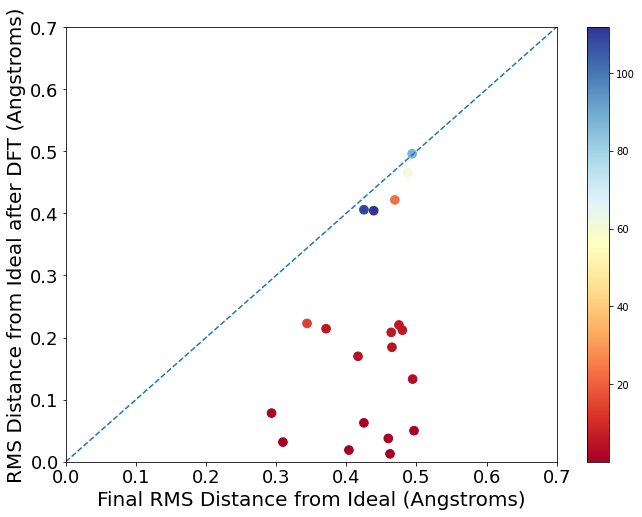

In [19]:
plt.figure(figsize = [11,8])
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(np.array(start_scores), np.array(final_scores), c = rvalues2, vmin=min(rvalues2), vmax=max(rvalues2), s=75, cmap=cm,  marker = 'o',)
plt.colorbar(sc, )
# plt.scatter(x,y)
plt.plot(range(2),range(2), '--')
plt.xlabel('Starting RMS Distance from Ideal (Angstroms)',fontsize = 20)
plt.ylabel('RMS Distance from Ideal after DFT (Angstroms)', fontsize = 20)
# plt.ylabel('Energy(eV/atom)', fontsize = 20)

plt.xlim([0.,0.7])
plt.ylim([0,0.7])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.show()


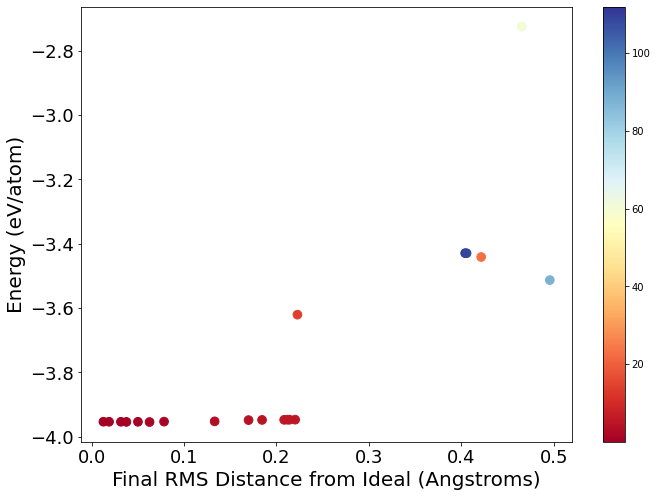

In [21]:
plt.figure(figsize = [11,8])
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(np.array(final_scores), np.array(final_energies2)/24,c = rvalues2, vmin=min(rvalues2), vmax=max(rvalues2), s=75, cmap=cm,  marker = 'o',)
plt.colorbar(sc, )
# plt.scatter(x,y)
# plt.plot(range(2),range(2), '--')
plt.xlabel('Final RMS Distance from Ideal (Angstroms)',fontsize = 20)
# plt.ylabel('RMS Distance from Ideal after DFT (Angstroms)', fontsize = 20)
plt.ylabel('Energy (eV/atom)', fontsize = 20)

# plt.xlim([0.,0.7])
# plt.ylim([0,0.7])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.show()
